# Benchmark Results
This notebook visualizes the output from the different models on different classification problems

In [1]:
import collections
import glob
import json
import os

import numpy as np
import pandas as pd
from plotnine import *

from saged import utils

## Set Up Functions and Get Metadata

In [2]:
def split_sample_names(df_row):
    train_samples = df_row['train samples'].split(',')
    val_samples = df_row['val samples'].split(',')
    
    return train_samples, val_samples

def create_dataset_stat_df(metrics_df, sample_to_study, 
                           sample_metadata, sample_to_label, disease,):

    data_dict = {'train_disease_count': [],
                 'train_healthy_count': [],
                 'val_disease_count': [],
                 'val_healthy_count': [],
                 'accuracy': [],
                 'balanced_accuracy': [],
                 'subset_fraction': [],
                 'seed': [],
                 'model': []
                }
    for _, row in metrics_df.iterrows():
        # Keep analysis simple for now



        data_dict['seed'].append(row['seed'])    
        data_dict['subset_fraction'].append(row['healthy_used'])
        data_dict['accuracy'].append(row['accuracy'])
        data_dict['model'].append(row['supervised'])
        if 'balanced_accuracy' in row:
            data_dict['balanced_accuracy'].append(row['balanced_accuracy'])

        train_samples, val_samples = split_sample_names(row)

        (train_studies, train_platforms, 
        train_diseases, train_disease_counts) = get_dataset_stats(train_samples,
                                                                  sample_to_study,
                                                                  sample_metadata,
                                                                  sample_to_label)
        data_dict['train_disease_count'].append(train_diseases[disease])
        data_dict['train_healthy_count'].append(train_diseases['healthy'])


        (val_studies, val_platforms, 
        val_diseases, val_disease_counts) = get_dataset_stats(val_samples,
                                                              sample_to_study,
                                                              sample_metadata,
                                                              sample_to_label)
        data_dict['val_disease_count'].append(val_diseases[disease])
        data_dict['val_healthy_count'].append(val_diseases['healthy'])

    stat_df = pd.DataFrame.from_dict(data_dict)
    
    stat_df['train_disease_percent'] = (stat_df['train_disease_count'] / 
                                        (stat_df['train_disease_count'] + 
                                         stat_df['train_healthy_count']))
    
    stat_df['val_disease_percent'] = (stat_df['val_disease_count'] /
                                      (stat_df['val_disease_count'] + 
                                       stat_df['val_healthy_count']))
    
    stat_df['train_val_diff'] = abs(stat_df['train_disease_percent'] - 
                                    stat_df['val_disease_percent'])
    stat_df['train_count'] = (stat_df['train_disease_count'] + 
                              stat_df['train_healthy_count'])
    
    return stat_df

def get_dataset_stats(sample_list, sample_to_study, sample_metadata, sample_to_label):
    studies = []
    platforms = []
    diseases = []
    study_disease_counts = {}

    for sample in sample_list:
        study = sample_to_study[sample]
        studies.append(study)
        platform = sample_metadata[sample]['refinebio_platform'].lower()
        platforms.append(platform)

        disease = sample_to_label[sample]
        diseases.append(disease)
        
        if study in study_disease_counts:
            study_disease_counts[study][disease] = study_disease_counts[study].get(disease, 0) + 1
        else:
            study_disease_counts[study] = {disease: 1}
            
    studies = collections.Counter(studies)
    platforms = collections.Counter(platforms)
    diseases = collections.Counter(diseases)

    
    return studies, platforms, diseases, study_disease_counts

In [3]:
def return_unlabeled():
    # For use in a defaultdict
    return 'unlabeled'

In [4]:
data_dir = '../../data/'
map_file = os.path.join(data_dir, 'sample_classifications.pkl')

sample_to_label = utils.parse_map_file(map_file)
sample_to_label = collections.defaultdict(return_unlabeled, sample_to_label)

In [5]:
metadata_path = os.path.join(data_dir, 'aggregated_metadata.json')
metadata = None
with open(metadata_path) as json_file:
    metadata = json.load(json_file)
sample_metadata = metadata['samples']

In [6]:
experiments = metadata['experiments']
sample_to_study = {}
for study in experiments:
    for accession in experiments[study]['sample_accession_codes']:
        sample_to_study[accession] = study

## Sepsis classification

In [7]:
in_files = glob.glob('../../results/single_label.*')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/single_label.sepsis.pseudolabel.refinebio_labeled_dataset.3.tsv', '../../results/single_label.sepsis.PCA.deep_net.refinebio_labeled_dataset.4.tsv', '../../results/single_label.sepsis.deep_net.refinebio_labeled_dataset.1.tsv', '../../results/single_label.sepsis.PCA.pytorch_supervised.refinebio_labeled_dataset.3.tsv', '../../results/single_label.sepsis.PCA.pytorch_supervised.refinebio_labeled_dataset.2.tsv']


In [8]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    if len(model_info) == 4:
        unsupervised_model = model_info[0]
        supervised_model = model_info[1]
    else:
        unsupervised_model = 'untransformed'
        supervised_model = model_info[0]
             
    new_df['unsupervised'] = unsupervised_model
    new_df['supervised'] = supervised_model
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics

,accuracy,train studies,train sample count,unsupervised,supervised
0,0.843023,"GSE3037,GSE14882,GSE13015,GSE33118,GSE112811,G...",2599,untransformed,pseudolabel
1,0.975669,"GSE98793,GSE3037,GSE13015,GSE33118,GSE112811,G...",2293,untransformed,pseudolabel
2,0.795724,"GSE98793,GSE14882,GSE13015,GSE33118,GSE112811,...",2694,untransformed,pseudolabel
3,0.967342,"GSE98793,GSE14882,GSE3037,GSE33118,GSE3284,SRP...",2227,untransformed,pseudolabel
4,0.901709,"GSE98793,GSE14882,GSE3037,GSE13015,GSE112811,G...",2647,untransformed,pseudolabel
...,...,...,...,...,...
0,0.950241,"GSE65088,SRP049820,GSE5504,GSE38511,GSE33341,G...",2492,PCA,pytorch_supervised
1,0.840517,"GSE38511,GSE33341,GSE65682,GSE14844,SRP092402,...",2651,PCA,pytorch_supervised
2,0.964981,"GSE65088,SRP049820,GSE5504,GSE38511,GSE33341,G...",2344,PCA,pytorch_supervised
3,0.901361,"GSE65088,SRP049820,GSE5504,GSE33341,GSE65682,G...",2821,PCA,pytorch_supervised


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


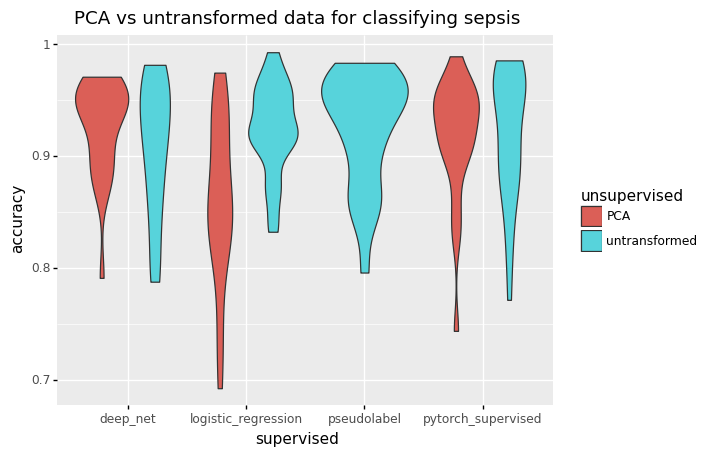

<ggplot: (8788365734891)>


In [9]:
plot = ggplot(sepsis_metrics, aes(x='supervised', y='accuracy', fill='unsupervised')) 
plot += geom_violin()
plot += ggtitle('PCA vs untransformed data for classifying sepsis')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


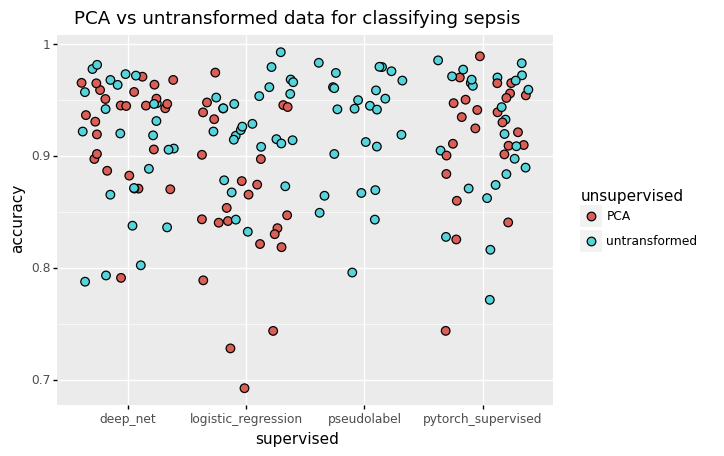

<ggplot: (8788529485138)>


In [10]:
plot = ggplot(sepsis_metrics, aes(x='supervised', y='accuracy', fill='unsupervised')) 
plot += geom_jitter(size=3)
plot += ggtitle('PCA vs untransformed data for classifying sepsis')
print(plot)

## All labels

In [11]:
in_files = glob.glob('../../results/all_labels.*')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/all_labels.deep_net.refinebio_labeled_dataset.2.tsv', '../../results/all_labels.PCA.logistic_regression.refinebio_labeled_dataset.0.tsv', '../../results/all_labels.deep_net.refinebio_labeled_dataset.0.tsv', '../../results/all_labels.PCA.logistic_regression.refinebio_labeled_dataset.4.tsv', '../../results/all_labels.PCA.deep_net.refinebio_labeled_dataset.1.tsv']


In [12]:
metrics = None
for path in in_files:
    if metrics is None:
        metrics = pd.read_csv(path, sep='\t')
        
        model_info = path.strip('.tsv').split('all_labels.')[-1]
        
        model_info = model_info.split('.')
        
        if len(model_info) == 4:
            unsupervised_model = model_info[0]
            supervised_model = model_info[1]
        else:
            unsupervised_model = 'untransformed'
            supervised_model = model_info[0]
             
        metrics['unsupervised'] = unsupervised_model
        metrics['supervised'] = supervised_model
    else:
        new_df = pd.read_csv(path, sep='\t')
        model_info = path.strip('.tsv').split('all_labels.')[-1]
        model_info = model_info.split('.')
        
        if len(model_info) == 4:
            unsupervised_model = model_info[0]
            supervised_model = model_info[1]
        else:
            unsupervised_model = 'untransformed'
            supervised_model = model_info[0]
             
        new_df['unsupervised'] = unsupervised_model
        new_df['supervised'] = supervised_model
        
        metrics = pd.concat([metrics, new_df])

metrics

,accuracy,train studies,train sample count,unsupervised,supervised
0,0.015056,"GSE15316,GSE9960,GSE51808,GSE84844,GSE45923,GS...",8175,untransformed,deep_net
1,0.019048,"GSE15316,GSE51808,GSE5504,GSE84844,GSE45923,GS...",7189,untransformed,deep_net
2,0.000000,"GSE15316,GSE9960,GSE51808,GSE5504,GSE84844,GSE...",8222,untransformed,deep_net
3,0.041231,"GSE9960,GSE45923,GSE5504,GSE98793,GSE112811,GS...",8512,untransformed,deep_net
4,0.002149,"GSE15316,GSE9960,GSE51808,GSE5504,GSE84844,GSE...",8838,untransformed,deep_net
...,...,...,...,...,...
0,0.002183,"GSE93272,E-MEXP-3567,GSE79150,SRP132709,GSE570...",8402,untransformed,logistic_regression
1,0.070588,"GSE42305,E-MEXP-3567,GSE61240,GSE79150,GSE9327...",8109,untransformed,logistic_regression
2,0.053706,"GSE42305,E-MEXP-3567,GSE61240,SRP132709,GSE791...",7981,untransformed,logistic_regression
3,0.017518,"GSE42305,GSE61240,SRP132709,GSE57065,GSE13015,...",8864,untransformed,logistic_regression


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


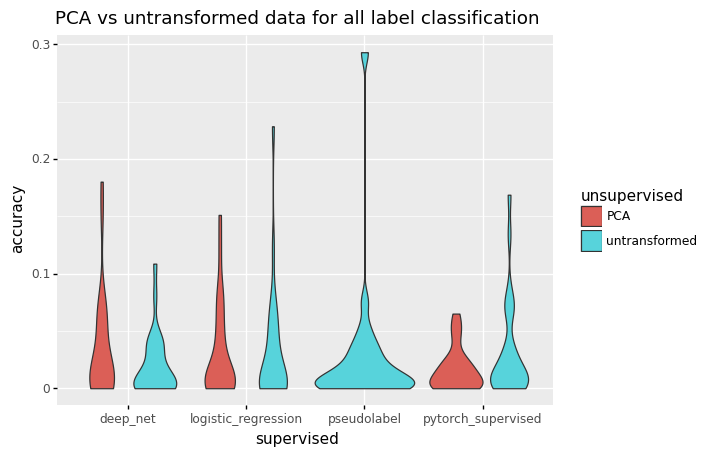

<ggplot: (8788529493330)>


In [13]:
plot = ggplot(metrics, aes(x='supervised', y='accuracy', fill='unsupervised')) 
plot += geom_violin()
plot += ggtitle('PCA vs untransformed data for all label classification')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


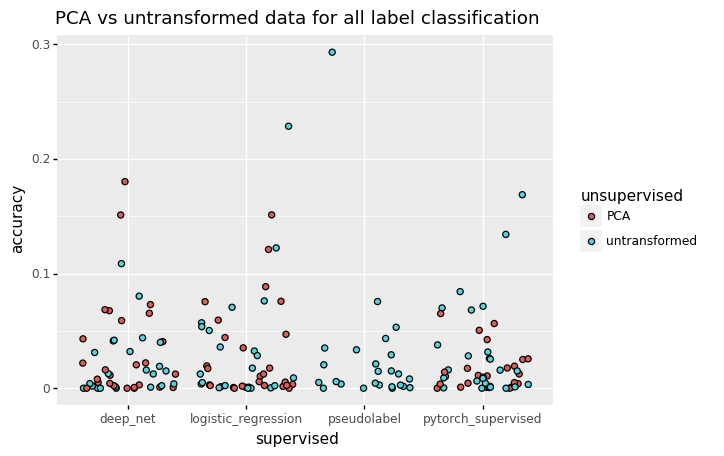

<ggplot: (8788527881385)>


In [14]:
plot = ggplot(metrics, aes(x='supervised', y='accuracy', fill='unsupervised')) 
plot += geom_jitter(size=2)
plot += ggtitle('PCA vs untransformed data for all label classification')
print(plot)

# Subsets of healthy labels

In [15]:
in_files = glob.glob('../../results/subset_label.sepsis*')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/subset_label.sepsis.pytorch_supervised.refinebio_labeled_dataset.4.tsv', '../../results/subset_label.sepsis.deep_net.refinebio_labeled_dataset.2.tsv', '../../results/subset_label.sepsis.logistic_regression.refinebio_labeled_dataset.3.tsv', '../../results/subset_label.sepsis.PCA.deep_net.refinebio_labeled_dataset.4.tsv', '../../results/subset_label.sepsis.deep_net.refinebio_labeled_dataset.1.tsv']


In [16]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    if len(model_info) == 4:
        unsupervised_model = model_info[0]
        supervised_model = model_info[1]
    else:
        unsupervised_model = 'untransformed'
        supervised_model = model_info[0]
             
    new_df['unsupervised'] = unsupervised_model
    new_df['supervised'] = supervised_model
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics = sepsis_metrics.rename({'fraction of healthy used': 'healthy_used'}, axis='columns')
sepsis_metrics['healthy_used'] = sepsis_metrics['healthy_used'].round(1)
    
sepsis_metrics

,accuracy,train studies,train sample count,healthy_used,unsupervised,supervised
0,0.910112,"GSE112811,GSE99039,GSE33341,GSE93606,GSE28750,...",1386,0.1,untransformed,pytorch_supervised
1,0.917431,"GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...",1548,0.2,untransformed,pytorch_supervised
2,0.923077,"GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...",1710,0.3,untransformed,pytorch_supervised
3,0.926667,"GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...",1871,0.4,untransformed,pytorch_supervised
4,0.953216,"GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...",2033,0.5,untransformed,pytorch_supervised
...,...,...,...,...,...,...
35,0.951087,"GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...",1425,0.6,PCA,pytorch_supervised
36,0.978261,"GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...",1478,0.7,PCA,pytorch_supervised
37,0.961957,"GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...",1530,0.8,PCA,pytorch_supervised
38,0.951087,"GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...",1583,0.9,PCA,pytorch_supervised


In [17]:
print(sepsis_metrics[sepsis_metrics['healthy_used'] == 1])

    accuracy                                      train studies  \
9   0.941392  GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...   
19  0.962919  GSE50635,GSE33341,GSE3284,GSE38511,SRP049820,S...   
29  0.924794  GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...   
39  0.908333  GSE112811,GSE99039,GSE3284,GSE93606,GSE28750,G...   
49  0.880460  GSE112811,GSE99039,GSE33341,GSE50635,GSE93606,...   
..       ...                                                ...   
39  0.996610  GSE64338,GSE83456,GSE26378,GSE65682,GSE65088,G...   
9   0.909605  GSE65088,GSE42834,GSE37171,GSE98793,GSE50635,S...   
19  1.000000  GSE33119,GSE65088,GSE42834,GSE50635,GSE66099,G...   
29  0.982456  GSE33119,GSE50635,GSE66099,GSE98793,GSE57065,G...   
39  0.961957  GSE33119,GSE65088,GSE98793,GSE66099,GSE50635,G...   

    train sample count  healthy_used   unsupervised           supervised  
9                 2842           1.0  untransformed   pytorch_supervised  
19                2279           1.0  untrans

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


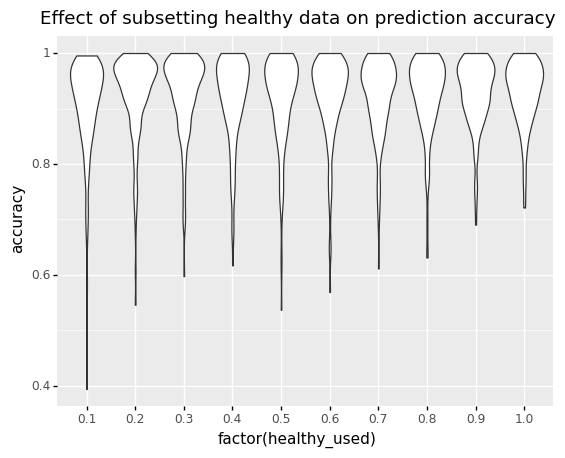

<ggplot: (8788527880674)>


In [18]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', )) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


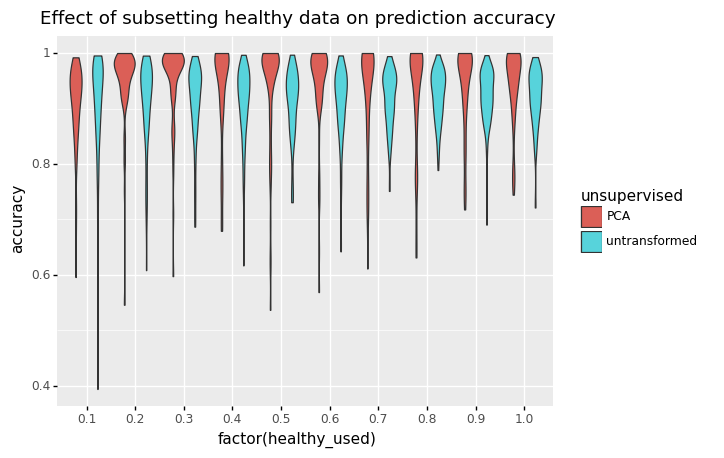

<ggplot: (8788527860234)>


In [19]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='unsupervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


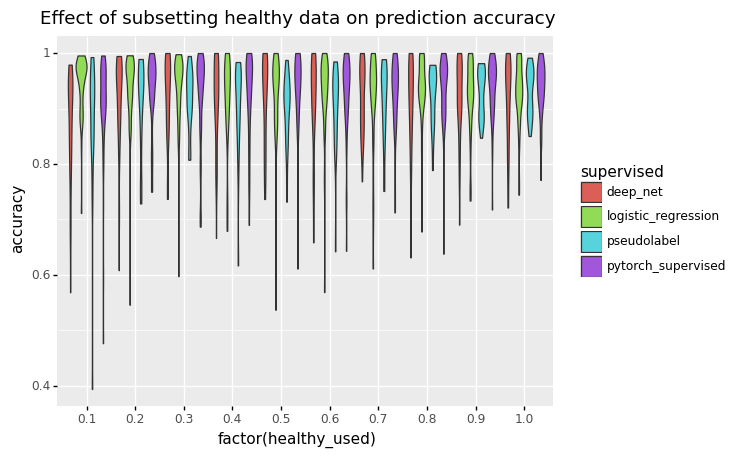

<ggplot: (8788527839949)>


In [20]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## Same analysis, but with tb instead of sepsis

In [21]:
in_files = glob.glob('../../results/subset_label.tb*')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/subset_label.tb.deep_net.refinebio_labeled_dataset.1.tsv', '../../results/subset_label.tb.PCA.pytorch_supervised.refinebio_labeled_dataset.0.tsv', '../../results/subset_label.tb.pytorch_supervised.refinebio_labeled_dataset.3.tsv', '../../results/subset_label.tb.PCA.deep_net.refinebio_labeled_dataset.1.tsv', '../../results/subset_label.tb.PCA.pytorch_supervised.refinebio_labeled_dataset.1.tsv']


In [22]:
tuberculosis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    if len(model_info) == 4:
        unsupervised_model = model_info[0]
        supervised_model = model_info[1]
    else:
        unsupervised_model = 'untransformed'
        supervised_model = model_info[0]
             
    new_df['unsupervised'] = unsupervised_model
    new_df['supervised'] = supervised_model
        
    tuberculosis_metrics = pd.concat([tuberculosis_metrics, new_df])
    
tuberculosis_metrics = tuberculosis_metrics.rename({'fraction of healthy used': 'healthy_used'}, axis='columns')
tuberculosis_metrics['healthy_used'] = tuberculosis_metrics['healthy_used'].round(1)
tuberculosis_metrics

,accuracy,train studies,train sample count,healthy_used,unsupervised,supervised
0,0.676301,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",771,0.1,untransformed,deep_net
1,0.665025,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",923,0.2,untransformed,deep_net
2,0.562232,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",1075,0.3,untransformed,deep_net
3,0.688213,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",1227,0.4,untransformed,deep_net
4,0.593857,"GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...",1379,0.5,untransformed,deep_net
...,...,...,...,...,...,...
35,0.493113,"GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...",544,0.6,PCA,pytorch_supervised
36,0.487603,"GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...",569,0.7,PCA,pytorch_supervised
37,0.330579,"GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...",593,0.8,PCA,pytorch_supervised
38,0.584022,"GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...",617,0.9,PCA,pytorch_supervised


In [23]:
print(tuberculosis_metrics[tuberculosis_metrics['healthy_used'] == 1])

    accuracy                                      train studies  \
9   0.726862  GSE26440,GSE55201,GSE98793,SRP092402,GSE93606,...   
19  0.978193  GSE45291,GSE38511,GSE14844,GSE98793,SRP092402,...   
29  0.648780  GSE45291,GSE26440,GSE38511,GSE14844,GSE98793,S...   
39  0.700809  GSE45291,GSE26440,GSE38511,GSE14844,GSE98793,S...   
49  0.647399  GSE45291,GSE26440,GSE38511,GSE14844,GSE55201,G...   
..       ...                                                ...   
49  0.625241  GSE26378,GSE8121,E-MEXP-1635,GSE5504,GSE66099,...   
9   0.000000  GSE83456,GSE8121,GSE4607,SRP071965,GSE99039,GS...   
19  0.613793  GSE83456,GSE8121,GSE4607,GSE99039,GSE65682,GSE...   
29  0.513812  GSE8121,GSE4607,GSE58411,GSE65682,GSE26049,GSE...   
39  0.258953  GSE83456,GSE8121,GSE58411,GSE26049,GSE93272,GS...   

    train sample count  healthy_used   unsupervised          supervised  
9                 2140           1.0  untransformed            deep_net  
19                2262           1.0  untransfo

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


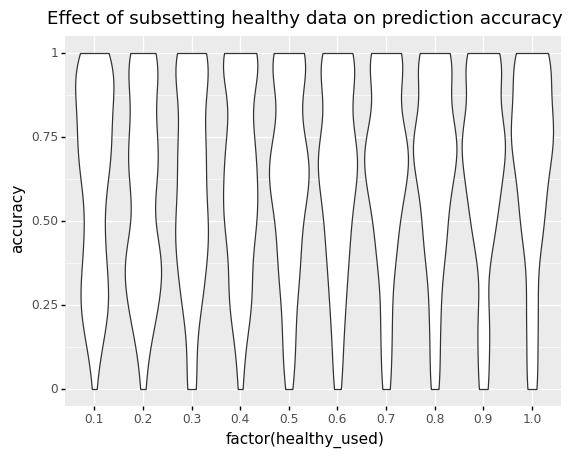

<ggplot: (8788527687355)>


In [24]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


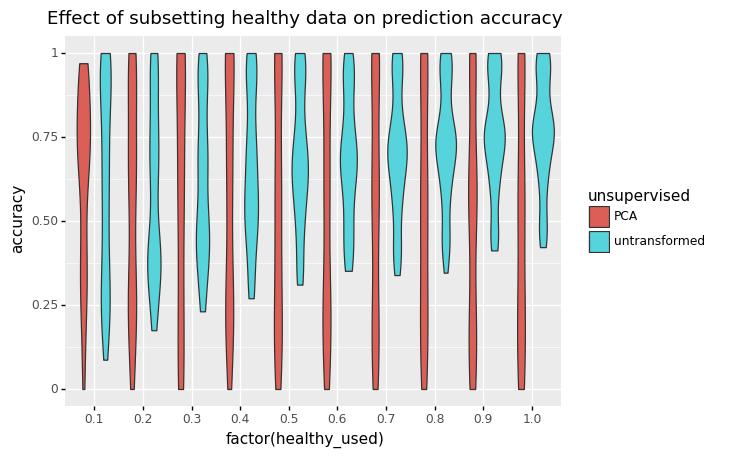

<ggplot: (8788527548983)>


In [25]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='unsupervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


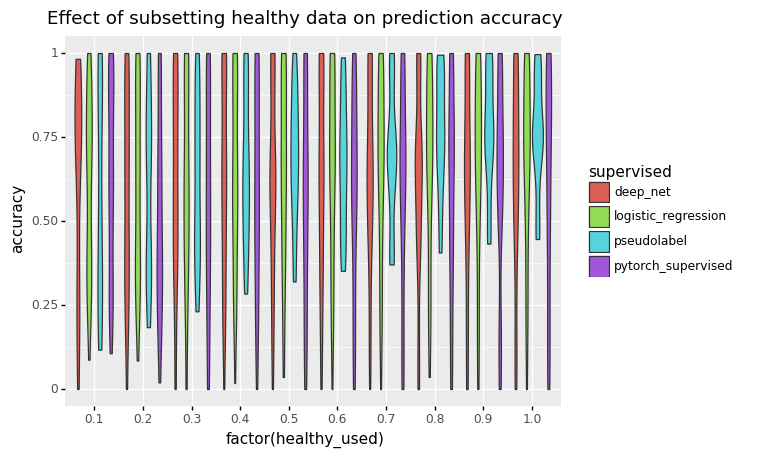

<ggplot: (8788527548796)>


In [26]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## Supervised Results Only
The results above show that unsupervised learning mostly hurts performance rather than helping.
The visualizations below compare each model based only on its supervised results.

In [27]:
supervised_sepsis = sepsis_metrics[sepsis_metrics['unsupervised'] == 'untransformed']

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


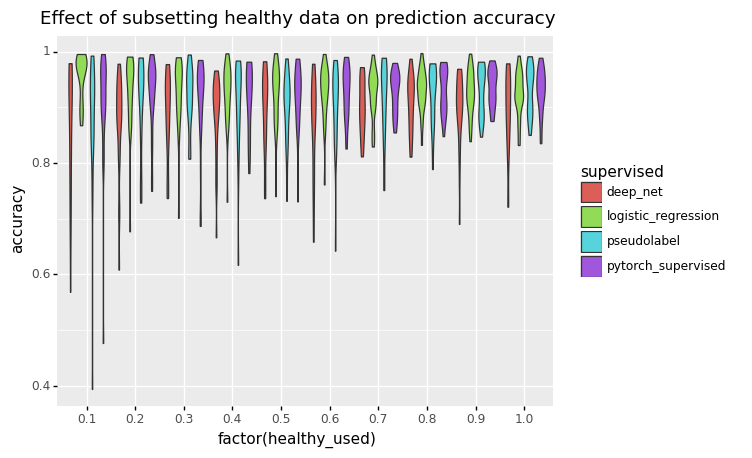

<ggplot: (8788529495260)>


In [28]:
plot = ggplot(supervised_sepsis, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

In [29]:
supervised_tb = tuberculosis_metrics[tuberculosis_metrics['unsupervised'] == 'untransformed']

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


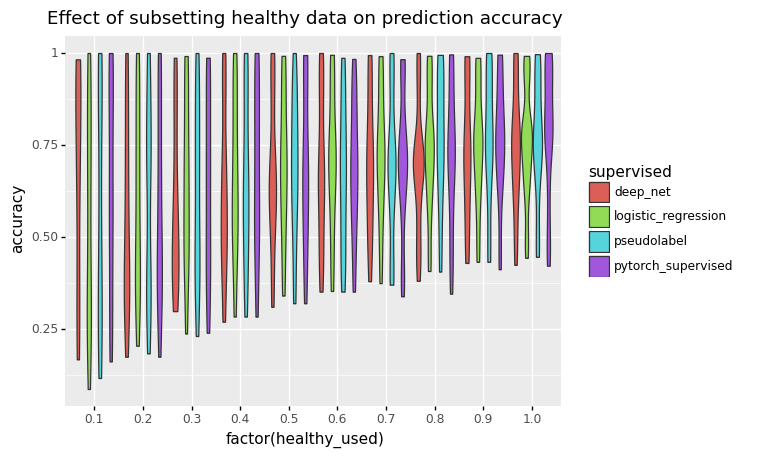

<ggplot: (8788527687406)>


In [30]:
plot = ggplot(supervised_tb, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


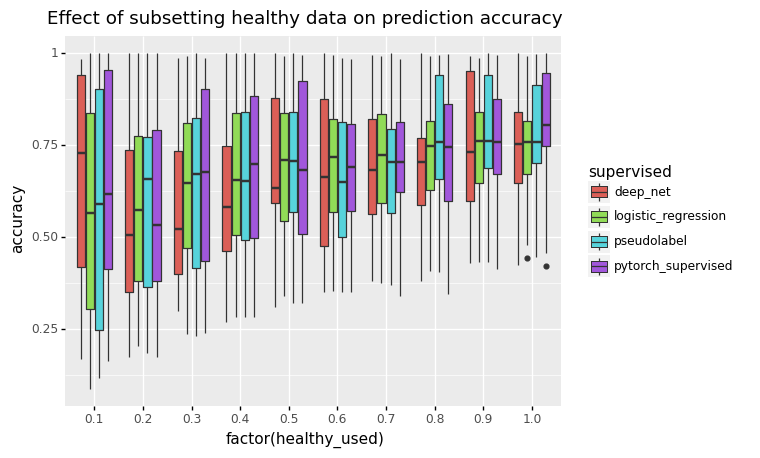

<ggplot: (8788527473526)>


In [31]:
plot = ggplot(supervised_tb, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_boxplot()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## Batch Effect Correction

In [32]:
in_files = glob.glob('../../results/subset_label.sepsis*be_corrected.tsv')
print(in_files[:5])

['../../results/subset_label.sepsis.pytorch_supervised.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/subset_label.sepsis.deep_net.refinebio_labeled_dataset.0.be_corrected.tsv', '../../results/subset_label.sepsis.pytorch_supervised.refinebio_labeled_dataset.1.be_corrected.tsv', '../../results/subset_label.sepsis.deep_net.refinebio_labeled_dataset.3.be_corrected.tsv', '../../results/subset_label.sepsis.pytorch_supervised.refinebio_labeled_dataset.2.be_corrected.tsv']


In [33]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    print(model_info)
    model_info = model_info.split('.')
    print(model_info)
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics = sepsis_metrics.rename({'fraction of healthy used': 'healthy_used'}, axis='columns')
sepsis_metrics['healthy_used'] = sepsis_metrics['healthy_used'].round(1)
    
sepsis_metrics

pytorch_supervised.refinebio_labeled_dataset.4.be_corrected
['pytorch_supervised', 'refinebio_labeled_dataset', '4', 'be_corrected']
deep_net.refinebio_labeled_dataset.0.be_corrected
['deep_net', 'refinebio_labeled_dataset', '0', 'be_corrected']
pytorch_supervised.refinebio_labeled_dataset.1.be_corrected
['pytorch_supervised', 'refinebio_labeled_dataset', '1', 'be_corrected']
deep_net.refinebio_labeled_dataset.3.be_corrected
['deep_net', 'refinebio_labeled_dataset', '3', 'be_corrected']
pytorch_supervised.refinebio_labeled_dataset.2.be_corrected
['pytorch_supervised', 'refinebio_labeled_dataset', '2', 'be_corrected']
logistic_regression.refinebio_labeled_dataset.2.be_corrected
['logistic_regression', 'refinebio_labeled_dataset', '2', 'be_corrected']
logistic_regression.refinebio_labeled_dataset.1.be_corrected
['logistic_regression', 'refinebio_labeled_dataset', '1', 'be_corrected']
deep_net.refinebio_labeled_dataset.4.be_corrected
['deep_net', 'refinebio_labeled_dataset', '4', 'be_corr

,accuracy,train studies,train sample count,healthy_used,supervised
0,0.808989,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",1386,0.1,pytorch_supervised
1,0.926606,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",1548,0.2,pytorch_supervised
2,0.800000,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",1710,0.3,pytorch_supervised
3,0.766667,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",1871,0.4,pytorch_supervised
4,0.789474,"GSE61635,GSE93606,SRP071965,GSE64338,GSE4607,G...",2033,0.5,pytorch_supervised
...,...,...,...,...,...
45,0.774854,"GSE65682,GSE45923,GSE37171,GSE98583,GSE95233,G...",2044,0.6,pytorch_supervised
46,0.909091,"GSE65682,GSE45923,GSE37171,GSE98583,GSE95233,G...",2194,0.7,pytorch_supervised
47,0.810345,"GSE65682,GSE45923,GSE37171,GSE98583,GSE95233,G...",2344,0.8,pytorch_supervised
48,0.849315,"GSE65682,GSE45923,GSE37171,GSE98583,GSE95233,G...",2494,0.9,pytorch_supervised


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


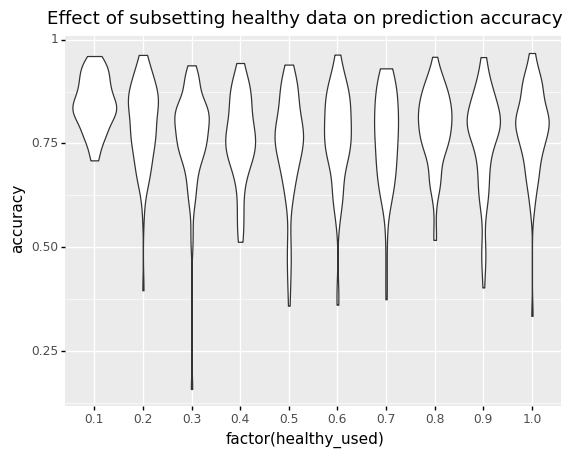

<ggplot: (8788527478098)>


In [34]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', )) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


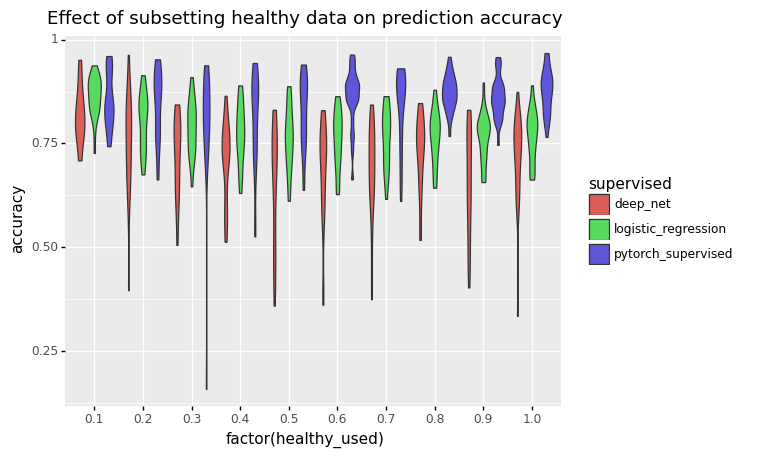

<ggplot: (8788527305304)>


In [35]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## TB Batch effect corrected

In [36]:
in_files = glob.glob('../../results/subset_label.tb*be_corrected.tsv')
print(in_files[:5])

['../../results/subset_label.tb.pytorch_supervised.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/subset_label.tb.logistic_regression.refinebio_labeled_dataset.0.be_corrected.tsv', '../../results/subset_label.tb.deep_net.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/subset_label.tb.logistic_regression.refinebio_labeled_dataset.2.be_corrected.tsv', '../../results/subset_label.tb.logistic_regression.refinebio_labeled_dataset.4.be_corrected.tsv']


In [37]:
tuberculosis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
        
    tuberculosis_metrics = pd.concat([tuberculosis_metrics, new_df])
    
tuberculosis_metrics = tuberculosis_metrics.rename({'fraction of healthy used': 'healthy_used'}, axis='columns')
tuberculosis_metrics['healthy_used'] = tuberculosis_metrics['healthy_used'].round(1)
tuberculosis_metrics

,accuracy,train studies,train sample count,healthy_used,supervised
0,0.762963,"GSE40553,GSE64338,GSE40240,GSE58411,GSE61635,S...",809,0.1,pytorch_supervised
1,0.682635,"GSE40553,GSE64338,GSE40240,GSE58411,GSE3037,GS...",959,0.2,pytorch_supervised
2,0.763819,"GSE40553,GSE64338,GSE40240,GSE58411,GSE3037,GS...",1109,0.3,pytorch_supervised
3,0.740260,"GSE40553,GSE64338,GSE40240,GSE58411,GSE3037,GS...",1259,0.4,pytorch_supervised
4,0.452471,"GSE40553,GSE64338,GSE40240,GSE58411,GSE3037,GS...",1409,0.5,pytorch_supervised
...,...,...,...,...,...
45,0.553991,"SRP077975,GSE14882,GSE3037,GSE40553,GSE33341,G...",1640,0.6,deep_net
46,0.836134,"SRP077975,GSE14882,GSE3037,GSE40553,GSE33341,G...",1798,0.7,deep_net
47,0.778626,"SRP077975,GSE14882,GSE3037,GSE40553,GSE33341,G...",1956,0.8,deep_net
48,0.860140,"SRP077975,GSE14882,GSE3037,GSE40553,GSE33341,G...",2114,0.9,deep_net


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


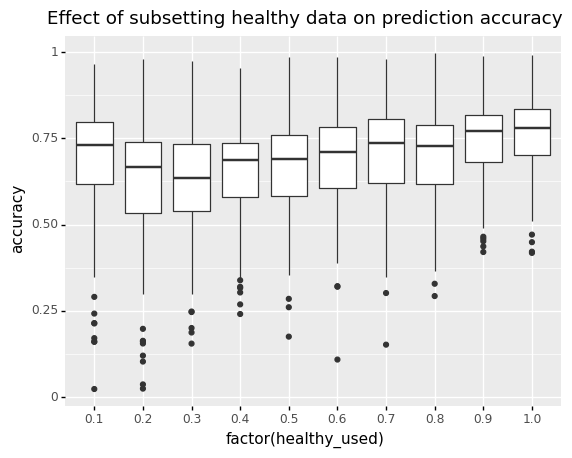

<ggplot: (8788527416706)>


In [38]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


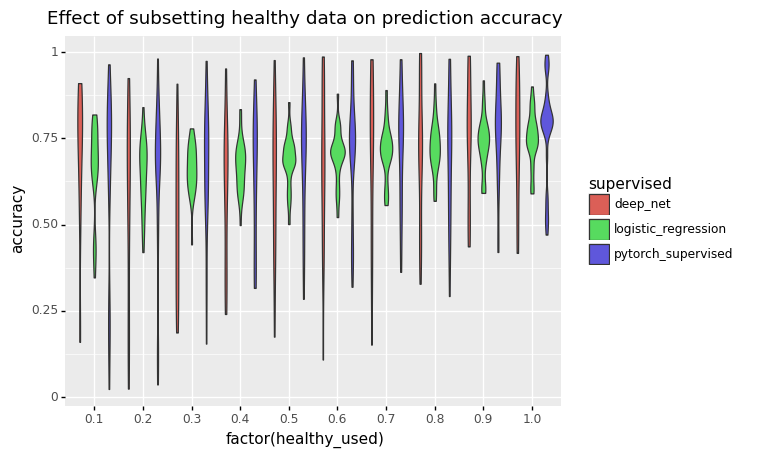

<ggplot: (8788527166236)>


In [39]:
plot = ggplot(tuberculosis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

## Better Metrics, Same Label Distribution in Train and Val sets

In [40]:
in_files = glob.glob('../../results/keep_ratios.sepsis*be_corrected.tsv')
print(in_files[:5])

['../../results/keep_ratios.sepsis.pytorch_supervised.refinebio_labeled_dataset.1.be_corrected.tsv', '../../results/keep_ratios.sepsis.pytorch_supervised.refinebio_labeled_dataset.3.be_corrected.tsv', '../../results/keep_ratios.sepsis.logistic_regression.refinebio_labeled_dataset.2.be_corrected.tsv', '../../results/keep_ratios.sepsis.logistic_regression.refinebio_labeled_dataset.0.be_corrected.tsv', '../../results/keep_ratios.sepsis.pytorch_supervised.refinebio_labeled_dataset.2.be_corrected.tsv']


In [41]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics = sepsis_metrics.rename({'fraction of data used': 'healthy_used'}, axis='columns')
sepsis_metrics['healthy_used'] = sepsis_metrics['healthy_used'].round(1)

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
sepsis_metrics = sepsis_metrics[~(sepsis_metrics['supervised'] == 'deep_net')]
sepsis_metrics['supervised'] = sepsis_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,healthy_used,supervised,seed
0,0.837881,0.744944,0.650519,"SRP136102,GSE57065,GSE33580,GSE51808,SRP077975...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",192,0.1,three_layer_net,1
1,0.847512,0.743258,0.652015,"SRP136102,GSE57065,GSE33580,GSE51808,SRP077975...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",385,0.2,three_layer_net,1
2,0.869984,0.819663,0.755287,"SRP136102,GSE57065,GSE33580,GSE51808,SRP077975...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",577,0.3,three_layer_net,1
3,0.919743,0.928652,0.871134,"SRP136102,GSE57065,GSE33580,GSE51808,SRP077975...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",770,0.4,three_layer_net,1
4,0.897271,0.885955,0.827027,"SRP136102,GSE57065,GSE33580,GSE51808,SRP077975...","GSM2449616,GSM830222,GSM265033,GSM830186,GSM13...","GSM1050991,GSM1051012,GSM1051015,GSM1051020,GS...",963,0.5,three_layer_net,1
...,...,...,...,...,...,...,...,...,...,...
45,0.786325,0.782175,0.823944,"GSE84844,GSE21592,GSE26049,GSE25504,GSE46914,G...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",958,0.6,logistic_regression,3
46,0.788462,0.787333,0.824156,"GSE84844,GSE21592,GSE26049,GSE25504,GSE46914,G...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1118,0.7,logistic_regression,3
47,0.822650,0.816938,0.855652,"GSE84844,GSE21592,GSE26049,GSE25504,GSE46914,G...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1278,0.8,logistic_regression,3
48,0.826923,0.819200,0.860104,"GSE84844,GSE21592,GSE26049,GSE25504,GSE46914,G...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1438,0.9,logistic_regression,3


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


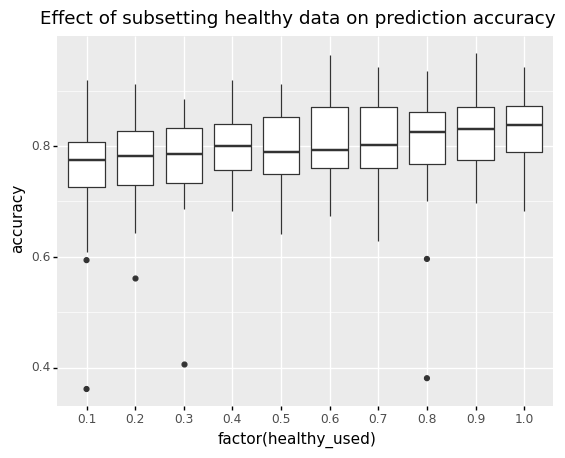

<ggplot: (8788526924770)>


In [42]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


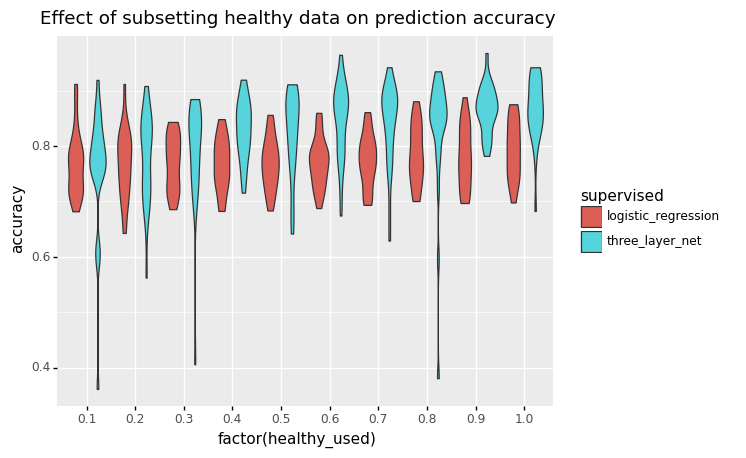

<ggplot: (8788527134127)>


In [43]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


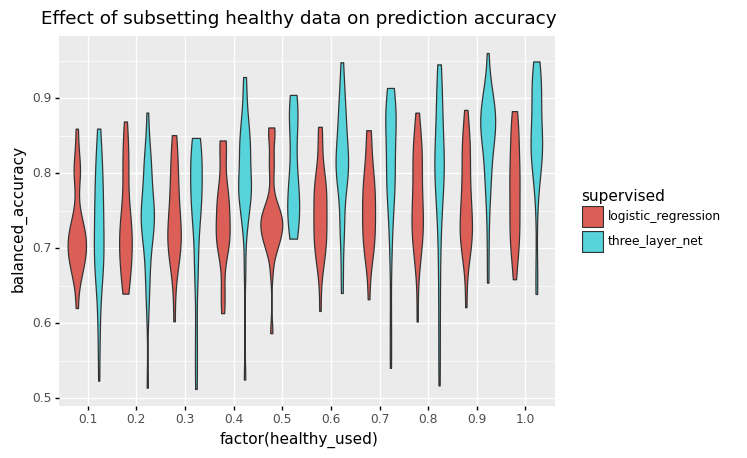

<ggplot: (8788526922409)>


In [44]:
plot = ggplot(sepsis_metrics, aes(x='factor(healthy_used)', y='balanced_accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

In [45]:
sepsis_stat_df = create_dataset_stat_df(sepsis_metrics, 
                                        sample_to_study, 
                                        sample_metadata, 
                                        sample_to_label,
                                        'sepsis')

sepsis_stat_df.tail(5)

,train_disease_count,train_healthy_count,val_disease_count,val_healthy_count,accuracy,balanced_accuracy,subset_fraction,seed,model,train_disease_percent,val_disease_percent,train_val_diff,train_count
495,601,357,293,175,0.786325,0.782175,0.6,3,logistic_regression,0.627349,0.626068,0.001280,958
496,698,420,293,175,0.788462,0.787333,0.7,3,logistic_regression,0.624329,0.626068,0.001739,1118
497,804,474,293,175,0.822650,0.816938,0.8,3,logistic_regression,0.629108,0.626068,0.003040,1278
498,900,538,293,175,0.826923,0.819200,0.9,3,logistic_regression,0.625869,0.626068,0.000199,1438
499,1001,597,293,175,0.831197,0.820312,1.0,3,logistic_regression,0.626408,0.626068,0.000340,1598


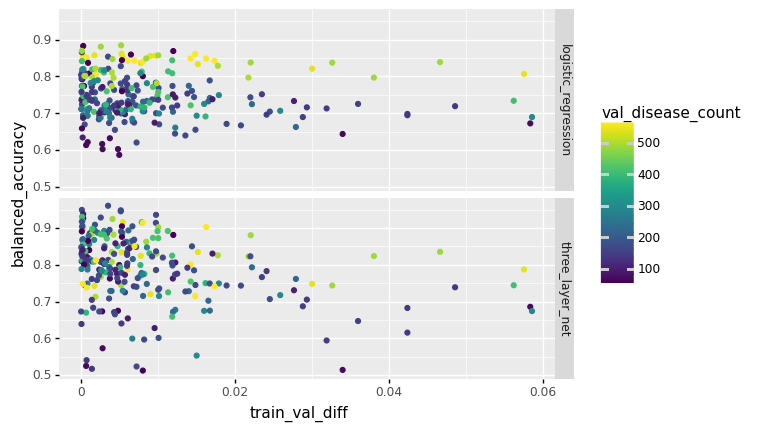

<ggplot: (8788527140410)>

In [46]:
ggplot(sepsis_stat_df, aes(x='train_val_diff', 
                           y='balanced_accuracy', 
                           color='val_disease_count')) + geom_point() + facet_grid('model ~ .')

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


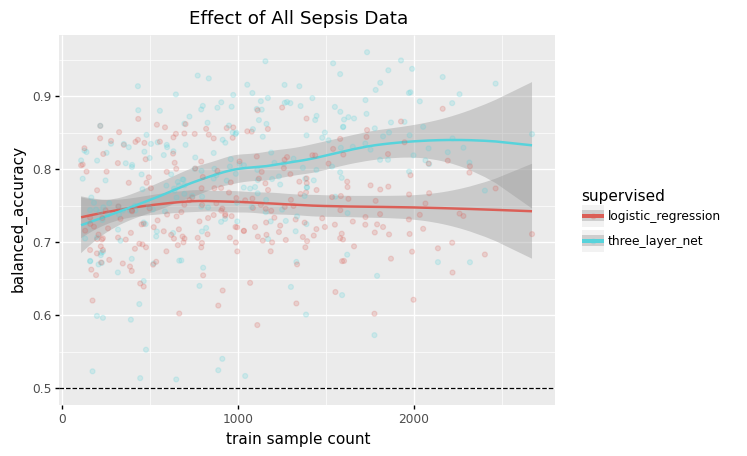

<ggplot: (8788527021472)>

In [47]:
plot = ggplot(sepsis_metrics, aes(x='train sample count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Effect of All Sepsis Data')
plot

## Same Distribution Tuberculosis

In [48]:
in_files = glob.glob('../../results/keep_ratios.tb*be_corrected.tsv')
print(in_files[:5])

['../../results/keep_ratios.tb.pytorch_supervised.refinebio_labeled_dataset.2.be_corrected.tsv', '../../results/keep_ratios.tb.pytorch_supervised.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/keep_ratios.tb.logistic_regression.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/keep_ratios.tb.logistic_regression.refinebio_labeled_dataset.3.be_corrected.tsv', '../../results/keep_ratios.tb.logistic_regression.refinebio_labeled_dataset.0.be_corrected.tsv']


In [49]:
tb_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    tb_metrics = pd.concat([tb_metrics, new_df])
    
tb_metrics = tb_metrics.rename({'fraction of data used': 'healthy_used'}, axis='columns')
tb_metrics['healthy_used'] = tb_metrics['healthy_used'].round(1)
tb_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,healthy_used,supervised,seed
0,0.981752,0.500000,0.000000,"GSE32198,GSE26440,SRP071965,GSE98583,GSE73408,...","GSM365212,SRR6870376,SRR3236047,GSM350151,GSM1...","GSM1331454,GSM1331455,GSM1331456,GSM1331457,GS...",158,0.1,pytorch_supervised,2
1,0.284672,0.635688,0.048544,"GSE8121,GSE32198,GSE26440,SRP071965,GSE98583,G...","GSM365212,SRR6870376,SRR3236047,GSM350151,GSM1...","GSM1331454,GSM1331455,GSM1331456,GSM1331457,GS...",316,0.2,pytorch_supervised,2
2,0.981752,0.500000,0.000000,"GSE8121,GSE32198,GSE26440,SRP071965,GSE98583,G...","GSM365212,SRR6870376,SRR3236047,GSM350151,GSM1...","GSM1331454,GSM1331455,GSM1331456,GSM1331457,GS...",474,0.3,pytorch_supervised,2
3,0.981752,0.500000,0.000000,"GSE8121,GSE32198,GSE26440,SRP071965,GSE98583,G...","GSM365212,SRR6870376,SRR3236047,GSM350151,GSM1...","GSM1331454,GSM1331455,GSM1331456,GSM1331457,GS...",632,0.4,pytorch_supervised,2
4,0.978102,0.498141,0.000000,"GSE8121,GSE32198,GSE26440,SRP071965,GSE98583,G...","GSM365212,SRR6870376,SRR3236047,GSM350151,GSM1...","GSM1331454,GSM1331455,GSM1331456,GSM1331457,GS...",790,0.5,pytorch_supervised,2
...,...,...,...,...,...,...,...,...,...,...
45,0.845659,0.731784,0.600000,"GSE45923,GSE61635,GSE93606,GSE26378,GSE4607,GS...","GSM955687,SRR3236060,SRR6870382,GSM830222,SRR3...","GSM1225041,GSM1225042,GSM1225043,GSM1225044,GS...",1211,0.6,logistic_regression,2
46,0.855305,0.711480,0.579439,"GSE45923,GSE61635,GSE93606,GSE26378,GSE4607,GS...","GSM955687,SRR3236060,SRR6870382,GSM830222,SRR3...","GSM1225041,GSM1225042,GSM1225043,GSM1225044,GS...",1413,0.7,logistic_regression,2
47,0.852090,0.693537,0.549020,"GSE45923,GSE61635,GSE93606,GSE26378,GSE4607,GS...","GSM955687,SRR3236060,SRR6870382,GSM830222,SRR3...","GSM1225041,GSM1225042,GSM1225043,GSM1225044,GS...",1615,0.8,logistic_regression,2
48,0.852090,0.714718,0.581818,"GSE45923,GSE61635,GSE93606,GSE26378,GSE4607,GS...","GSM955687,SRR3236060,SRR6870382,GSM830222,SRR3...","GSM1225041,GSM1225042,GSM1225043,GSM1225044,GS...",1817,0.9,logistic_regression,2


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


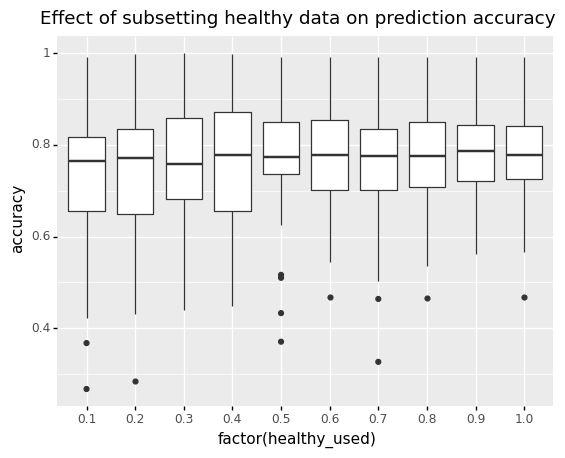

<ggplot: (8788526625609)>


In [50]:
plot = ggplot(tb_metrics, aes(x='factor(healthy_used)', y='accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


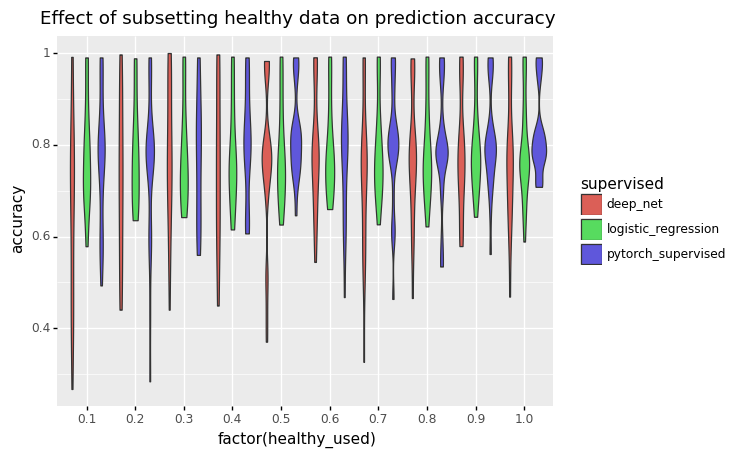

<ggplot: (8788526566129)>


In [51]:
plot = ggplot(tb_metrics, aes(x='factor(healthy_used)', y='accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


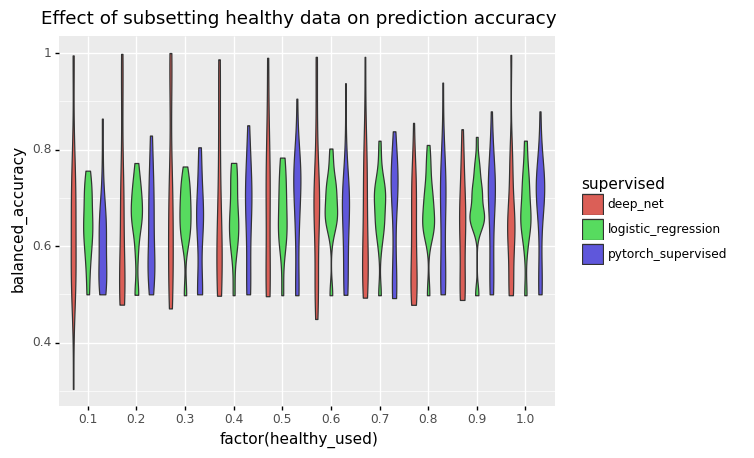

<ggplot: (8788526852810)>


In [52]:
plot = ggplot(tb_metrics, aes(x='factor(healthy_used)', y='balanced_accuracy', fill='supervised')) 
plot += geom_violin()
plot += ggtitle('Effect of subsetting healthy data on prediction accuracy')
print(plot)

In [53]:
tb_stat_df = create_dataset_stat_df(tb_metrics, 
                                    sample_to_study, 
                                    sample_metadata, 
                                    sample_to_label,
                                    'tb')

tb_stat_df.tail(5)

,train_disease_count,train_healthy_count,val_disease_count,val_healthy_count,accuracy,balanced_accuracy,subset_fraction,seed,model,train_disease_percent,val_disease_percent,train_val_diff,train_count
655,287,924,68,243,0.845659,0.731784,0.6,2,logistic_regression,0.236994,0.21865,0.018345,1211
656,320,1093,68,243,0.855305,0.711480,0.7,2,logistic_regression,0.226469,0.21865,0.007819,1413
657,354,1261,68,243,0.852090,0.693537,0.8,2,logistic_regression,0.219195,0.21865,0.000546,1615
658,393,1424,68,243,0.852090,0.714718,0.9,2,logistic_regression,0.216291,0.21865,0.002359,1817
659,441,1578,68,243,0.861736,0.731481,1.0,2,logistic_regression,0.218425,0.21865,0.000225,2019


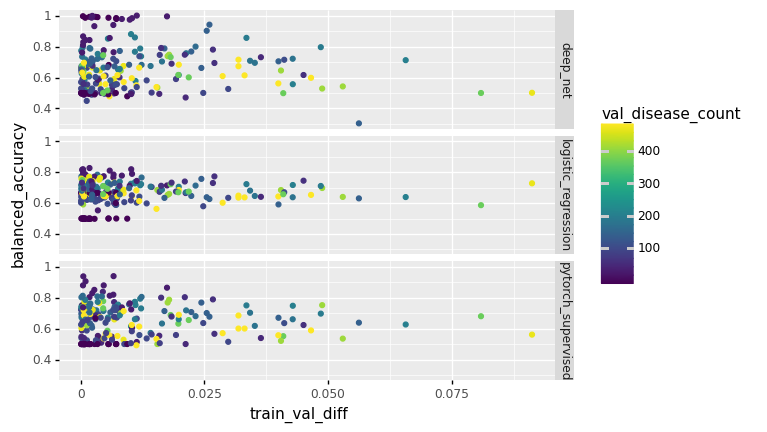

<ggplot: (8788502811835)>

In [54]:
ggplot(tb_stat_df, aes(x='train_val_diff', 
                       y='balanced_accuracy', 
                       color='val_disease_count')) + geom_point() + facet_grid('model ~ .')

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


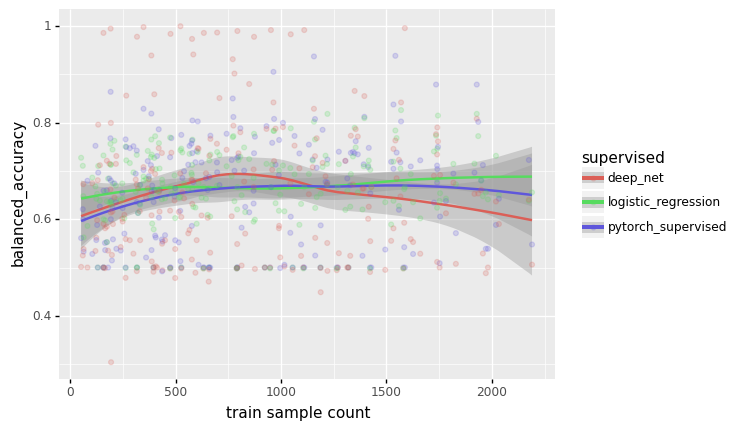

<ggplot: (8788526519830)>

In [55]:
plot = ggplot(tb_metrics, aes(x='train sample count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot

## Results from Small Datasets

In [56]:
in_files = glob.glob('../../results/small_subsets.sepsis*be_corrected.tsv')
print(in_files[:5])

['../../results/small_subsets.sepsis.pytorch_supervised.refinebio_labeled_dataset.0.be_corrected.tsv', '../../results/small_subsets.sepsis.deep_net.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/small_subsets.sepsis.pytorch_supervised.refinebio_labeled_dataset.1.be_corrected.tsv', '../../results/small_subsets.sepsis.logistic_regression.refinebio_labeled_dataset.0.be_corrected.tsv', '../../results/small_subsets.sepsis.logistic_regression.refinebio_labeled_dataset.2.be_corrected.tsv']


In [57]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics['train_count'] = sepsis_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
sepsis_metrics = sepsis_metrics[~(sepsis_metrics['supervised'] == 'deep_net')]
sepsis_metrics['supervised'] = sepsis_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,supervised,seed,train_count
0,0.484043,0.484043,0.645985,"GSE99039,GSE9960,GSE21592,GSE84844,SRP071965,G...","GSM350295,GSM648592,GSM365207,GSM251991,GSM157...","GSM201245,GSM201247,GSM201248,GSM201249,GSM201...",20,three_layer_net,0,20
1,0.694149,0.694149,0.622951,"GSE99039,GSE9960,GSE64457,GSE95233,SRP071965,G...","GSM350295,GSM648592,GSM365207,GSM251991,GSM157...","GSM201245,GSM201247,GSM201248,GSM201249,GSM201...",40,three_layer_net,0,40
2,0.744681,0.744681,0.755102,"GSE38511,GSE99039,GSE9960,GSE64457,GSE95233,SR...","GSM350295,GSM648592,GSM365207,GSM251991,GSM157...","GSM201245,GSM201247,GSM201248,GSM201249,GSM201...",60,three_layer_net,0,60
3,0.755319,0.755319,0.693333,"GSE38511,GSE99039,GSE9960,GSE83456,GSE64457,GS...","GSM350295,GSM648592,GSM365207,GSM251991,GSM157...","GSM201245,GSM201247,GSM201248,GSM201249,GSM201...",80,three_layer_net,0,80
4,0.659574,0.659574,0.740891,"GSE38511,GSE99039,GSE9960,GSE83456,GSE64457,GS...","GSM350295,GSM648592,GSM365207,GSM251991,GSM157...","GSM201245,GSM201247,GSM201248,GSM201249,GSM201...",100,three_layer_net,0,100
...,...,...,...,...,...,...,...,...,...,...
90,0.672222,0.672222,0.595890,"GSE45923,GSE99039,GSE33341,GSE28750,GSE11909,G...","GSM350256,GSM648619,GSM647541,GSM1586963,GSM16...","GSM1571528,GSM1571529,GSM1571530,GSM1571531,GS...",300,logistic_regression,4,300
91,0.686111,0.686111,0.622074,"GSE45923,GSE99039,GSE33341,GSE28750,GSE11909,G...","GSM350256,GSM648619,GSM647541,GSM1586963,GSM16...","GSM1571528,GSM1571529,GSM1571530,GSM1571531,GS...",320,logistic_regression,4,320
92,0.672222,0.672222,0.604027,"GSE45923,GSE99039,GSE33341,GSE28750,GSE11909,G...","GSM350256,GSM648619,GSM647541,GSM1586963,GSM16...","GSM1571528,GSM1571529,GSM1571530,GSM1571531,GS...",340,logistic_regression,4,340
93,0.680556,0.680556,0.620462,"GSE45923,GSE99039,GSE33341,GSE28750,GSE11909,G...","GSM350256,GSM648619,GSM647541,GSM1586963,GSM16...","GSM1571528,GSM1571529,GSM1571530,GSM1571531,GS...",360,logistic_regression,4,360


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


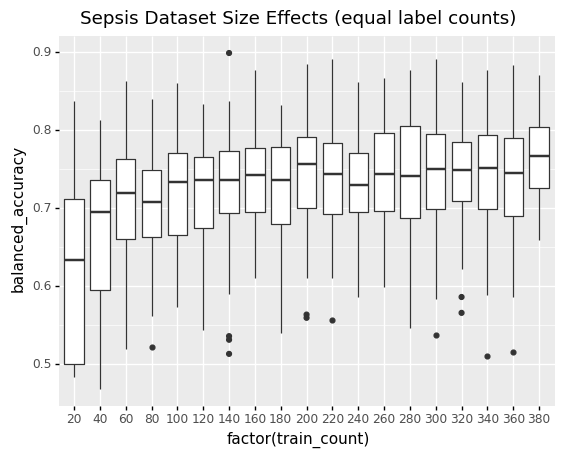

<ggplot: (8788502884190)>


In [58]:
plot = ggplot(sepsis_metrics, aes(x='factor(train_count)', y='balanced_accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Sepsis Dataset Size Effects (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


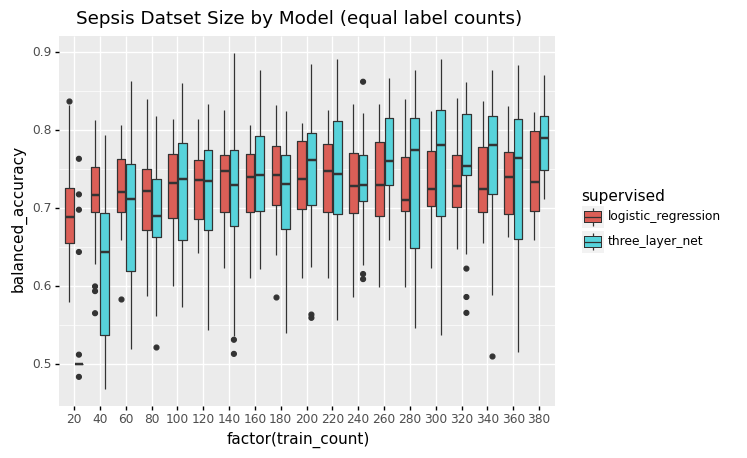

<ggplot: (8788502918943)>


In [59]:
plot = ggplot(sepsis_metrics, aes(x='factor(train_count)', y='balanced_accuracy', fill='supervised')) 
plot += geom_boxplot()
plot += ggtitle('Sepsis Datset Size by Model (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


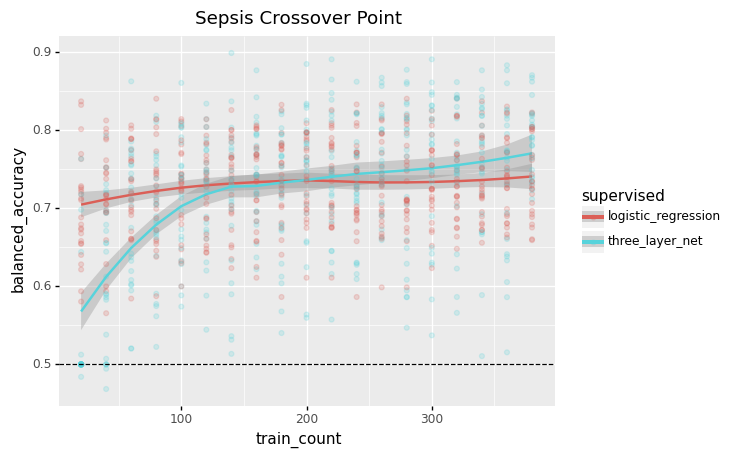

<ggplot: (8788502635261)>

In [60]:
plot = ggplot(sepsis_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Sepsis Crossover Point')
plot

## Small Training Set TB

In [61]:
in_files = glob.glob('../../results/small_subsets.tb*be_corrected.tsv')
print(in_files[:5])

['../../results/small_subsets.tb.deep_net.refinebio_labeled_dataset.2.be_corrected.tsv', '../../results/small_subsets.tb.pytorch_supervised.refinebio_labeled_dataset.1.be_corrected.tsv', '../../results/small_subsets.tb.pytorch_supervised.refinebio_labeled_dataset.2.be_corrected.tsv', '../../results/small_subsets.tb.deep_net.refinebio_labeled_dataset.4.be_corrected.tsv', '../../results/small_subsets.tb.deep_net.refinebio_labeled_dataset.3.be_corrected.tsv']


In [62]:
tb_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    tb_metrics = pd.concat([tb_metrics, new_df])
    
tb_metrics['train_count'] = tb_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
tb_metrics = tb_metrics[~(tb_metrics['supervised'] == 'deep_net')]
tb_metrics['supervised'] = tb_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
tb_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,supervised,seed,train_count
0,0.604895,0.604895,0.368715,"GSE99039,SRP092402,GSE73408,GSE19491,SRP071965...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",20,three_layer_net,1,20
1,0.636364,0.636364,0.440860,"GSE99039,GSE95233,E-MEXP-1635,SRP092402,GSE734...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",40,three_layer_net,1,40
2,0.548951,0.548951,0.652291,"GSE99039,GSE95233,E-MEXP-1635,SRP092402,GSE734...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",60,three_layer_net,1,60
3,0.590909,0.590909,0.670423,"GSE99039,GSE73408,GSE3037,GSE19491,GSE39088,GS...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",80,three_layer_net,1,80
4,0.688811,0.688811,0.565854,"GSE99039,GSE73408,GSE3037,GSE19491,GSE39088,GS...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",100,three_layer_net,1,100
...,...,...,...,...,...,...,...,...,...,...
71,0.584270,0.584270,0.288462,"GSE21592,GSE14844,GSE9960,GSE38511,SRP071965,G...","SRR4784509,GSM484573,GSM2203688,SRR4784278,SRR...","GSM1050948,GSM1050971,GSM1050988,GSM1892913,GS...",300,three_layer_net,3,300
72,0.539326,0.539326,0.145833,"GSE21592,GSE14844,GSE9960,GSE38511,GSE5504,SRP...","SRR4784509,GSM484573,GSM2203688,SRR4784278,SRR...","GSM1050948,GSM1050971,GSM1050988,GSM1892913,GS...",320,three_layer_net,3,320
73,0.691011,0.691011,0.763948,"GSE21592,GSE14844,GSE9960,GSE38511,GSE5504,SRP...","SRR4784509,GSM484573,GSM2203688,SRR4784278,SRR...","GSM1050948,GSM1050971,GSM1050988,GSM1892913,GS...",340,three_layer_net,3,340
74,0.747191,0.747191,0.693878,"GSE21592,GSE14844,GSE9960,GSE38511,GSE5504,SRP...","SRR4784509,GSM484573,GSM2203688,SRR4784278,SRR...","GSM1050948,GSM1050971,GSM1050988,GSM1892913,GS...",360,three_layer_net,3,360


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


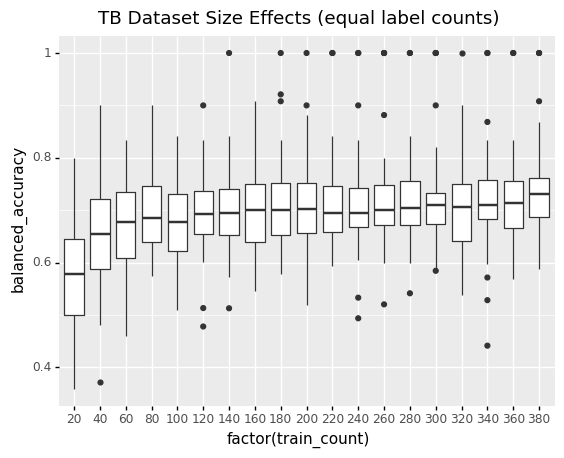

<ggplot: (8788502919051)>


In [63]:
plot = ggplot(tb_metrics, aes(x='factor(train_count)', y='balanced_accuracy')) 
plot += geom_boxplot()
plot += ggtitle('TB Dataset Size Effects (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


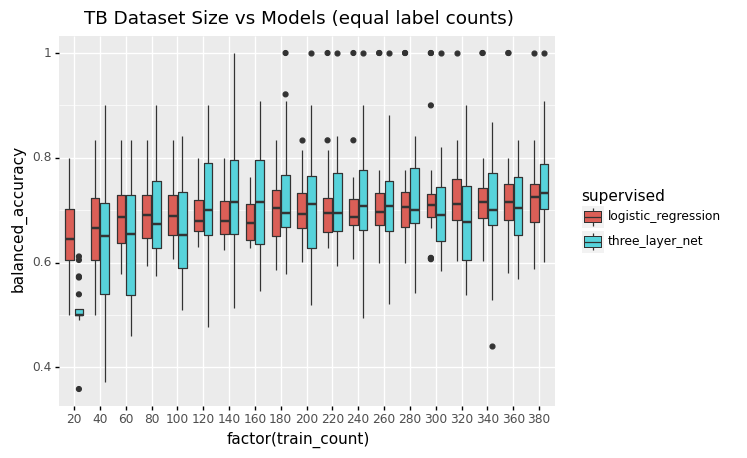

<ggplot: (8788502504783)>


In [64]:
plot = ggplot(tb_metrics, aes(x='factor(train_count)', y='balanced_accuracy', fill='supervised')) 
plot += geom_boxplot()
plot += ggtitle('TB Dataset Size vs Models (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


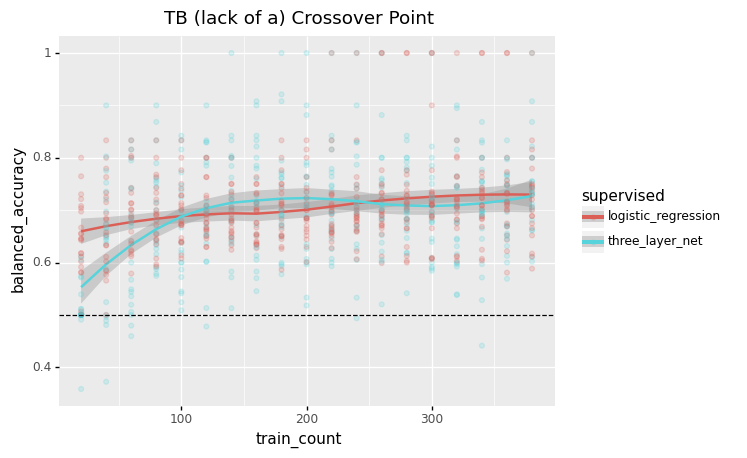

<ggplot: (8788502365450)>

In [65]:
plot = ggplot(tb_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth(method='loess')
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('TB (lack of a) Crossover Point')
plot

## Small training sets without be correction

In [68]:
in_files = glob.glob('../../results/small_subsets.sepsis*.tsv')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/small_subsets.sepsis.logistic_regression.refinebio_labeled_dataset.3.tsv', '../../results/small_subsets.sepsis.deep_net.refinebio_labeled_dataset.2.tsv', '../../results/small_subsets.sepsis.deep_net.refinebio_labeled_dataset.4.tsv', '../../results/small_subsets.sepsis.pytorch_supervised.refinebio_labeled_dataset.3.tsv', '../../results/small_subsets.sepsis.logistic_regression.refinebio_labeled_dataset.2.tsv']


In [69]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics['train_count'] = sepsis_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
sepsis_metrics = sepsis_metrics[~(sepsis_metrics['supervised'] == 'deep_net')]
sepsis_metrics['supervised'] = sepsis_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,supervised,seed,train_count
0,0.881048,0.881048,0.888469,"GSE84844,GSE19491,GSE66099,GSE11755,GSE13904,G...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",20,logistic_regression,refinebio_labeled_dataset,20
1,0.949597,0.949597,0.950298,"GSE40586,GSE33341,GSE84844,GSE57065,GSE13904,G...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",40,logistic_regression,refinebio_labeled_dataset,40
2,0.951613,0.951613,0.953125,"GSE40586,GSE33341,GSE84844,GSE57065,GSE13904,G...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",60,logistic_regression,refinebio_labeled_dataset,60
3,0.931452,0.931452,0.931452,"GSE40586,GSE33341,GSE84844,GSE57065,GSE13904,G...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",80,logistic_regression,refinebio_labeled_dataset,80
4,0.955645,0.955645,0.956693,"GSE40586,GSE33341,GSE84844,GSE57065,SRP049820,...","GSM264992,GSM1617681,GSM1586944,GSM350349,GSM1...","E-MEXP-1635-04SE57HA300104,E-MEXP-1635-04SE58H...",100,logistic_regression,refinebio_labeled_dataset,100
...,...,...,...,...,...,...,...,...,...,...
90,0.932292,0.932292,0.930851,"GSE19491,GSE26049,SRP077975,GSE93606,GSE45923,...","GSM648655,GSM2500376,GSM251944,GSM350358,GSM35...","GSM1404211,GSM1404212,GSM1404219,GSM1404220,GS...",300,three_layer_net,refinebio_labeled_dataset,300
91,0.856771,0.856771,0.833837,"GSE19491,GSE26049,SRP077975,GSE93606,GSE45923,...","GSM648655,GSM2500376,GSM251944,GSM350358,GSM35...","GSM1404211,GSM1404212,GSM1404219,GSM1404220,GS...",320,three_layer_net,refinebio_labeled_dataset,320
92,0.819010,0.819010,0.789713,"GSE19491,GSE26049,SRP077975,GSE93606,GSE45923,...","GSM648655,GSM2500376,GSM251944,GSM350358,GSM35...","GSM1404211,GSM1404212,GSM1404219,GSM1404220,GS...",340,three_layer_net,refinebio_labeled_dataset,340
93,0.903646,0.903646,0.896067,"GSE19491,GSE26049,SRP077975,GSE93606,GSE45923,...","GSM648655,GSM2500376,GSM251944,GSM350358,GSM35...","GSM1404211,GSM1404212,GSM1404219,GSM1404220,GS...",360,three_layer_net,refinebio_labeled_dataset,360


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


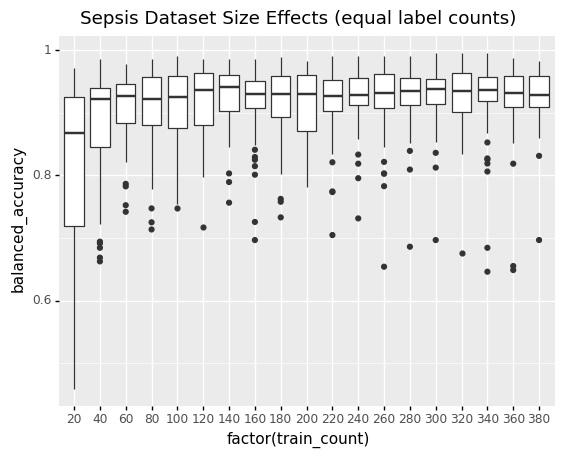

<ggplot: (8788502760090)>


In [70]:
plot = ggplot(sepsis_metrics, aes(x='factor(train_count)', y='balanced_accuracy')) 
plot += geom_boxplot()
plot += ggtitle('Sepsis Dataset Size Effects (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


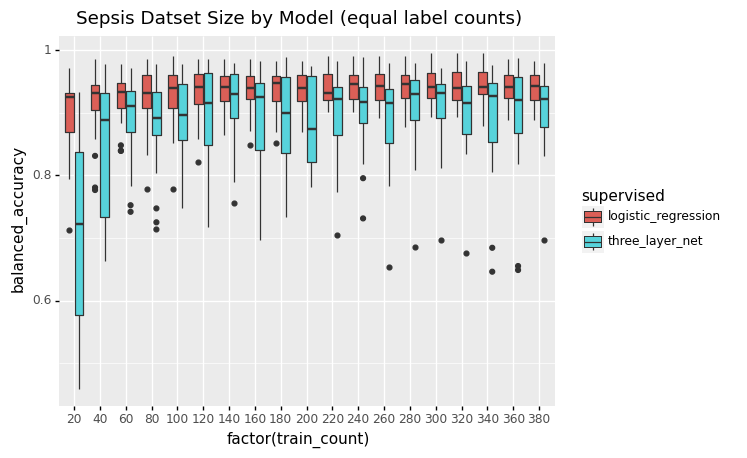

<ggplot: (8788501979025)>


In [71]:
plot = ggplot(sepsis_metrics, aes(x='factor(train_count)', y='balanced_accuracy', fill='supervised')) 
plot += geom_boxplot()
plot += ggtitle('Sepsis Datset Size by Model (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


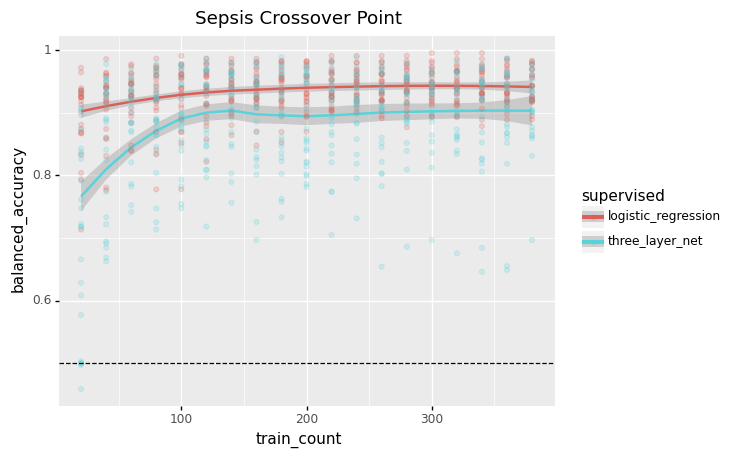

<ggplot: (8788501962117)>

In [72]:
plot = ggplot(sepsis_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Sepsis Crossover Point')
plot

## TB Not Batch Effect Corrected

In [83]:
in_files = glob.glob('../../results/small_subsets.tb*.tsv')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/small_subsets.tb.pytorch_supervised.refinebio_labeled_dataset.1.tsv', '../../results/small_subsets.tb.pytorch_supervised.refinebio_labeled_dataset.2.tsv', '../../results/small_subsets.tb.logistic_regression.refinebio_labeled_dataset.2.tsv', '../../results/small_subsets.tb.deep_net.refinebio_labeled_dataset.0.tsv', '../../results/small_subsets.tb.pytorch_supervised.refinebio_labeled_dataset.3.tsv']


In [84]:
tb_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    tb_metrics = pd.concat([tb_metrics, new_df])
    
tb_metrics['train_count'] = tb_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
tb_metrics = tb_metrics[~(tb_metrics['supervised'] == 'deep_net')]
tb_metrics['supervised'] = tb_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
tb_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,supervised,seed,train_count
0,0.664336,0.664336,0.657143,"SRP071965,GSE73408,GSE98793,SRP136102,GSE93606...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",20,three_layer_net,refinebio_labeled_dataset,20
1,0.681818,0.681818,0.669091,"E-MEXP-1635,SRP071965,GSE73408,GSE98793,SRP136...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",40,three_layer_net,refinebio_labeled_dataset,40
2,0.681818,0.681818,0.669091,"E-MEXP-1635,SRP071965,GSE73408,GSE98793,SRP136...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",60,three_layer_net,refinebio_labeled_dataset,60
3,0.660839,0.660839,0.654804,"GSE98793,SRP092402,GSE33341,GSE28750,GSE55201,...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",80,three_layer_net,refinebio_labeled_dataset,80
4,0.657343,0.657343,0.652482,"GSE98793,SRP092402,GSE33341,GSE28750,GSE55201,...","GSM484628,SRR4785064,GSM1892936,SRR4784236,GSM...","GSM2203540,GSM2203541,GSM2203542,GSM2203543,GS...",100,three_layer_net,refinebio_labeled_dataset,100
...,...,...,...,...,...,...,...,...,...,...
90,0.500000,0.500000,0.000000,"GSE73408,GSE45291,GSE58411,SRP092402,GSE79150,...","SRR4785022,SRR4785088,GSM2203581,SRR4784602,GS...","SRR3745139,SRR3745147,SRR3745171,SRR3745172,SR...",300,logistic_regression,refinebio_labeled_dataset,300
91,0.500000,0.500000,0.000000,"GSE73408,GSE45291,GSE58411,SRP092402,GSE79150,...","SRR4785022,SRR4785088,GSM2203581,SRR4784602,GS...","SRR3745139,SRR3745147,SRR3745171,SRR3745172,SR...",320,logistic_regression,refinebio_labeled_dataset,320
92,0.500000,0.500000,0.000000,"GSE73408,GSE45291,GSE58411,SRP092402,GSE79150,...","SRR4785022,SRR4785088,GSM2203581,SRR4784602,GS...","SRR3745139,SRR3745147,SRR3745171,SRR3745172,SR...",340,logistic_regression,refinebio_labeled_dataset,340
93,0.500000,0.500000,0.000000,"GSE73408,GSE45291,GSE58411,SRP092402,GSE79150,...","SRR4785022,SRR4785088,GSM2203581,SRR4784602,GS...","SRR3745139,SRR3745147,SRR3745171,SRR3745172,SR...",360,logistic_regression,refinebio_labeled_dataset,360


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


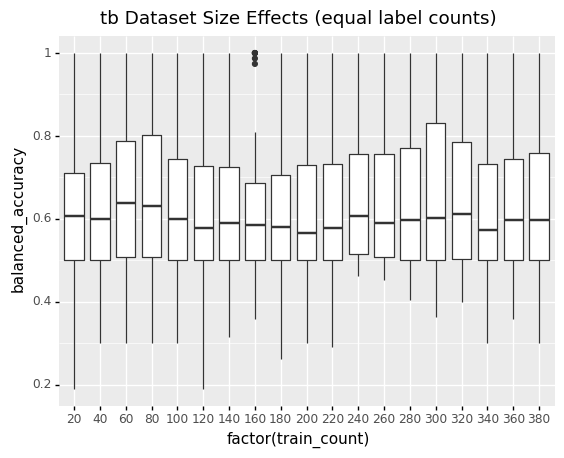

<ggplot: (8788501594058)>


In [85]:
plot = ggplot(tb_metrics, aes(x='factor(train_count)', y='balanced_accuracy')) 
plot += geom_boxplot()
plot += ggtitle('tb Dataset Size Effects (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


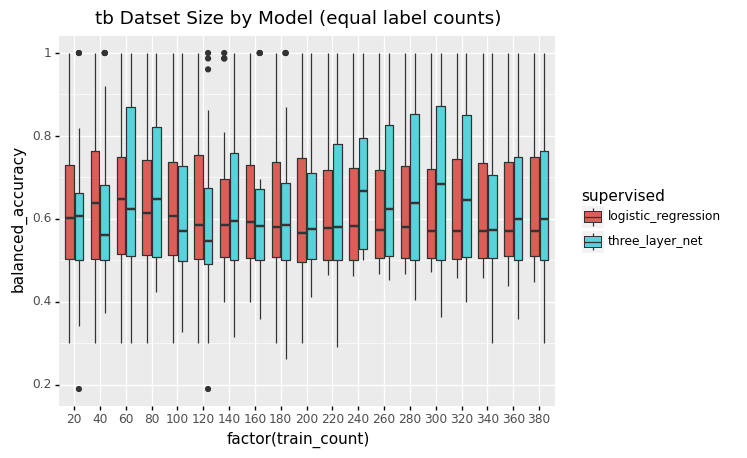

<ggplot: (8788501364092)>


In [86]:
plot = ggplot(tb_metrics, aes(x='factor(train_count)', y='balanced_accuracy', fill='supervised')) 
plot += geom_boxplot()
plot += ggtitle('tb Datset Size by Model (equal label counts)')
print(plot)

/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


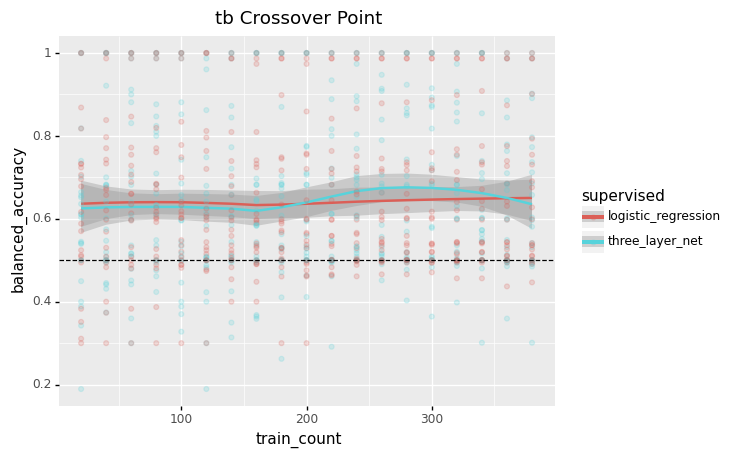

<ggplot: (8788501115338)>

In [87]:
plot = ggplot(tb_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('tb Crossover Point')
plot

## Large training sets without be correction

In [88]:
in_files = glob.glob('../../results/keep_ratios.sepsis*.tsv')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/keep_ratios.sepsis.logistic_regression.refinebio_labeled_dataset.4.tsv', '../../results/keep_ratios.sepsis.deep_net.refinebio_labeled_dataset.0.tsv', '../../results/keep_ratios.sepsis.logistic_regression.refinebio_labeled_dataset.2.tsv', '../../results/keep_ratios.sepsis.pytorch_supervised.refinebio_labeled_dataset.1.tsv', '../../results/keep_ratios.sepsis.logistic_regression.refinebio_labeled_dataset.0.tsv']


In [89]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics['train_count'] = sepsis_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
sepsis_metrics = sepsis_metrics[~(sepsis_metrics['supervised'] == 'deep_net')]
sepsis_metrics['supervised'] = sepsis_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,supervised,seed,train_count
0,0.941392,0.951194,0.893333,"GSE99039,GSE14844,GSE93777,GSE51808,GSE19491,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",216,0.1,logistic_regression,refinebio_labeled_dataset,216
1,0.967033,0.977941,0.938776,"GSE99039,GSE14844,GSE93777,GSE51808,GSE45537,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",432,0.2,logistic_regression,refinebio_labeled_dataset,432
2,0.948718,0.960891,0.906667,"GSE99039,GSE14844,GSE93777,GSE51808,GSE45537,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",648,0.3,logistic_regression,refinebio_labeled_dataset,648
3,0.930403,0.939045,0.874172,"GSE45923,GSE99039,GSE14844,GSE93777,GSE51808,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",865,0.4,logistic_regression,refinebio_labeled_dataset,865
4,0.937729,0.953538,0.888889,"GSE45923,GSE99039,GSE14844,GSE93777,GSE51808,G...","GSM1568775,GSM647618,GSM2631191,GSM648598,GSM1...","E-MEXP-3567-C13,E-MEXP-3567-H_C08,E-MEXP-3567-...",1081,0.5,logistic_regression,refinebio_labeled_dataset,1081
...,...,...,...,...,...,...,...,...,...,...,...
45,0.901709,0.914598,0.916667,"GSE46914,SRP077975,GSE40586,GSE66890,GSE13015,...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",958,0.6,three_layer_net,refinebio_labeled_dataset,958
46,0.880342,0.883725,0.901060,"GSE46914,SRP077975,GSE40586,GSE66890,GSE13015,...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1118,0.7,three_layer_net,refinebio_labeled_dataset,1118
47,0.888889,0.897455,0.906810,"GSE46914,SRP077975,GSE40586,GSE66890,GSE13015,...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1278,0.8,three_layer_net,refinebio_labeled_dataset,1278
48,0.884615,0.906699,0.898876,"GSE46914,SRP077975,GSE40586,GSE66890,GSE13015,...","GSM647569,GSM648654,GSM365239,SRR1652976,GSM25...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",1438,0.9,three_layer_net,refinebio_labeled_dataset,1438


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


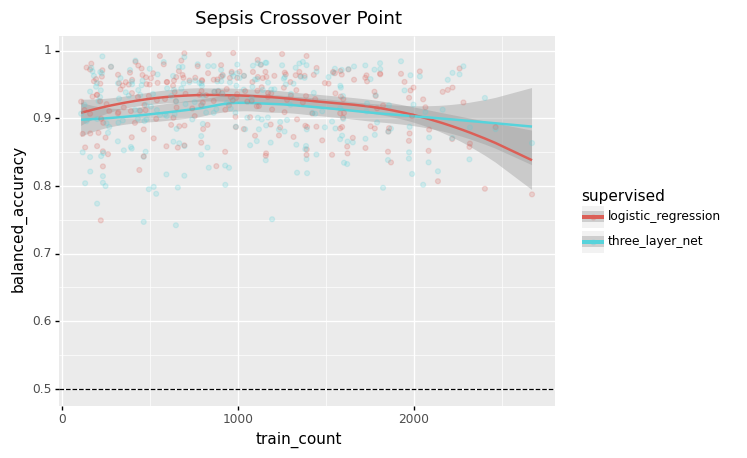

<ggplot: (8788499187002)>

In [92]:
plot = ggplot(sepsis_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Sepsis Crossover Point')
plot

## TB Not Batch Effect Corrected

In [93]:
in_files = glob.glob('../../results/keep_ratios.tb*.tsv')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/keep_ratios.tb.logistic_regression.refinebio_labeled_dataset.0.tsv', '../../results/keep_ratios.tb.pytorch_supervised.refinebio_labeled_dataset.1.tsv', '../../results/keep_ratios.tb.deep_net.refinebio_labeled_dataset.2.tsv', '../../results/keep_ratios.tb.logistic_regression.refinebio_labeled_dataset.1.tsv', '../../results/keep_ratios.tb.deep_net.refinebio_labeled_dataset.3.tsv']


In [94]:
tb_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-2]
        
    tb_metrics = pd.concat([tb_metrics, new_df])
    
tb_metrics['train_count'] = tb_metrics['train sample count']

# Looking at the training curves, deep_net isn't actually training
# I need to fix it going forward, but for now I can clean up the visualizations by removing it
tb_metrics = tb_metrics[~(tb_metrics['supervised'] == 'deep_net')]
tb_metrics['supervised'] = tb_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
tb_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,supervised,seed,train_count
0,0.360614,0.391619,0.269006,"GSE73408,GSE40553,GSE19491,GSE58411,GSE38511,G...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",52,0.1,logistic_regression,refinebio_labeled_dataset,52
1,0.415601,0.456938,0.289269,"GSE66099,GSE26378,GSE51808,GSE31348,GSE95233,S...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",105,0.2,logistic_regression,refinebio_labeled_dataset,105
2,0.401535,0.441409,0.277778,"GSE66099,GSE42834,GSE26378,GSE51808,GSE31348,G...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",158,0.3,logistic_regression,refinebio_labeled_dataset,158
3,0.404092,0.442746,0.287462,"GSE66099,GSE42834,GSE26378,GSE51808,GSE31348,G...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",210,0.4,logistic_regression,refinebio_labeled_dataset,210
4,0.450128,0.499513,0.295082,"GSE66099,GSE42834,GSE26378,GSE51808,GSE31348,G...","GSM777379,GSM996438,SRR3745139,GSM1892930,GSM2...","GSM1100843,GSM1100844,GSM1100845,GSM1100847,GS...",263,0.5,logistic_regression,refinebio_labeled_dataset,263
...,...,...,...,...,...,...,...,...,...,...,...
35,0.870841,0.893204,0.859574,"GSE66099,GSE28750,GSE64338,GSE9960,SRP049820,G...","GSM996367,GSM912842,SRR3235929,GSM824762,SRR47...","GSM1050948,GSM1050971,GSM1050988,GSM1050991,GS...",849,0.6,three_layer_net,refinebio_labeled_dataset,849
36,0.861057,0.885113,0.850526,"GSE66099,GSE28750,GSE64338,GSE9960,SRP049820,G...","GSM996367,GSM912842,SRR3235929,GSM824762,SRR47...","GSM1050948,GSM1050971,GSM1050988,GSM1050991,GS...",991,0.7,three_layer_net,refinebio_labeled_dataset,991
37,0.906067,0.902616,0.881773,"GSE66099,GSE28750,GSE64338,GSE9960,SRP049820,G...","GSM996367,GSM912842,SRR3235929,GSM824762,SRR47...","GSM1050948,GSM1050971,GSM1050988,GSM1050991,GS...",1132,0.8,three_layer_net,refinebio_labeled_dataset,1132
38,0.866928,0.889968,0.855932,"GSE66099,GSE28750,GSE64338,GSE9960,SRP049820,G...","GSM996367,GSM912842,SRR3235929,GSM824762,SRR47...","GSM1050948,GSM1050971,GSM1050988,GSM1050991,GS...",1274,0.9,three_layer_net,refinebio_labeled_dataset,1274


/home/ben/anaconda3/envs/saged/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


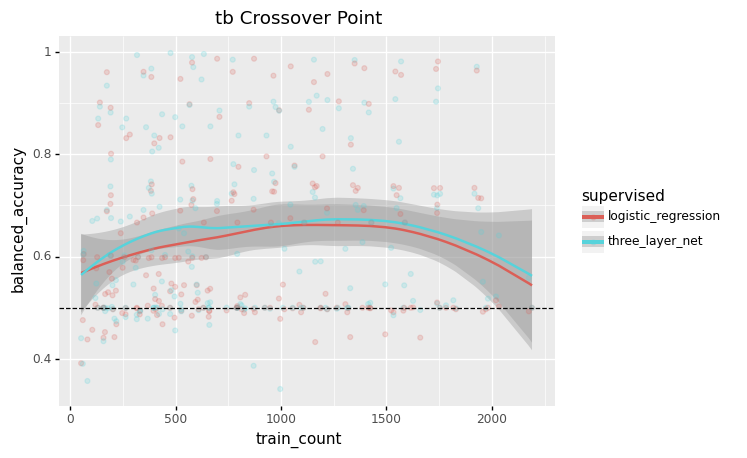

<ggplot: (8788497426764)>

In [99]:
plot = ggplot(tb_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('tb Crossover Point')
plot